**导入必要的包**

**paddle.fluid**--->PaddlePaddle深度学习框架

**numpy**---------->python基本库，用于科学计算

**os**------------------>python的模块，可使用该模块对操作系统进行操作

In [1]:
import paddle.fluid as fluid
import paddle
import numpy as np
import os


 **数据准备。**
 

In [2]:
BUF_SIZE=500
BATCH_SIZE=20

#用于训练的数据提供器，每次从缓存中随机读取批次大小的数据
train_reader = paddle.batch(
    paddle.reader.shuffle(paddle.dataset.uci_housing.train(), 
                          buf_size=BUF_SIZE),                    
    batch_size=BATCH_SIZE)   
#用于测试的数据提供器，每次从缓存中随机读取批次大小的数据
test_reader = paddle.batch(
    paddle.reader.shuffle(paddle.dataset.uci_housing.test(),
                          buf_size=BUF_SIZE),
    batch_size=BATCH_SIZE)


%matplotlib inline
import matplotlib.pyplot as plt
    

(3)打印看下数据是什么样的？PaddlePaddle接口提供的数据已经经过归一化等处理

(array([-0.02964322, -0.11363636,  0.39417967, -0.06916996,  0.14260276,
       -0.10109875,  0.30715859, -0.13176829, -0.24127857,  0.05489093,
        0.29196451, -0.2368098 ,  0.12850267]), array([15.6])),

In [3]:
#用于打印，查看uci_housing数据
train_data=paddle.dataset.uci_housing.train();
sampledata=next(train_data())
print(sampledata)

(array([-0.0405441 ,  0.06636364, -0.32356227, -0.06916996, -0.03435197,
        0.05563625, -0.03475696,  0.02682186, -0.37171335, -0.21419304,
       -0.33569506,  0.10143217, -0.21172912]), array([24.]))



**网络搭建**：


In [4]:
#定义张量变量x，表示13维的特征值
x = fluid.layers.data(name='x', shape=[13], dtype='float32')
#定义张量y,表示目标值
y = fluid.layers.data(name='y', shape=[1], dtype='float32')
#定义一个简单的线性网络,连接输入和输出的全连接层
#input:输入tensor;
#size:该层输出单元的数目
#act:激活函数
y_predict=fluid.layers.fc(input=x,size=1,act=None)

In [5]:
cost = fluid.layers.square_error_cost(input=y_predict, label=y) #求一个batch的损失值，均方差损失
avg_cost = fluid.layers.mean(cost)                              #对损失值求平均值

In [6]:
optimizer = fluid.optimizer.SGDOptimizer(learning_rate=0.001)
opts = optimizer.minimize(avg_cost)#随机梯度下降

In [7]:
test_program = fluid.default_main_program().clone(for_test=True)

 **模型训练评估** 

In [8]:

use_cuda = False                         #use_cuda为False,表示运算场所为CPU;use_cuda为True,表示运算场所为GPU           
place = fluid.CUDAPlace(0) if use_cuda else fluid.CPUPlace()
exe = fluid.Executor(place)              #创建一个Executor实例exe
exe.run(fluid.default_startup_program()) #Executor的run()方法执行startup_program(),进行参数初始化

[]

In [9]:
# 定义输入数据维度
feeder = fluid.DataFeeder(place=place, feed_list=[x, y])#feed_list:向模型输入的变量表或变量表名

In [10]:
iter=0;
iters=[]
train_costs=[]

def draw_train_process(iters,train_costs):
    title="training cost"
    plt.title(title, fontsize=24)
    plt.xlabel("iter", fontsize=14)
    plt.ylabel("cost", fontsize=14)
    plt.plot(iters, train_costs,color='red',label='training cost') 
    plt.grid()
    plt.show()

Pass:0, Cost:49.17825
Test:0, Cost:12.88026
Pass:1, Cost:68.59180
Test:1, Cost:34.34474
Pass:2, Cost:50.74639
Test:2, Cost:3.78723
Pass:3, Cost:91.38164
Test:3, Cost:5.56591
Pass:4, Cost:89.80331
Test:4, Cost:15.33361
Pass:5, Cost:81.86373
Test:5, Cost:6.44980
Pass:6, Cost:35.84973
Test:6, Cost:62.12038
Pass:7, Cost:38.39153
Test:7, Cost:5.18919
Pass:8, Cost:14.11417
Test:8, Cost:9.04340
Pass:9, Cost:54.93052
Test:9, Cost:3.06026
Pass:10, Cost:45.85416
Test:10, Cost:24.66337
Pass:11, Cost:40.35839
Test:11, Cost:4.67824
Pass:12, Cost:18.17240
Test:12, Cost:57.32441
Pass:13, Cost:18.66378
Test:13, Cost:18.86083
Pass:14, Cost:29.03704
Test:14, Cost:24.58334
Pass:15, Cost:53.72470
Test:15, Cost:7.77675
Pass:16, Cost:25.71045
Test:16, Cost:14.11803
Pass:17, Cost:36.62064
Test:17, Cost:57.35703
Pass:18, Cost:71.98928
Test:18, Cost:30.21002
Pass:19, Cost:21.67063
Test:19, Cost:13.48585
Pass:20, Cost:62.06688
Test:20, Cost:10.03267
Pass:21, Cost:44.94549
Test:21, Cost:5.85851
Pass:22, Cost:77.

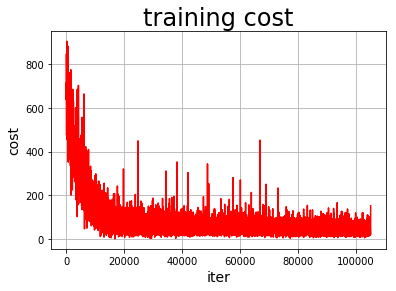

In [17]:
EPOCH_NUM=50
model_save_dir = "/home/aistudio/work/fit_a_line.inference.model"

for pass_id in range(EPOCH_NUM):                                  #训练EPOCH_NUM轮
    # 开始训练并输出最后一个batch的损失值
    train_cost = 0
    for batch_id, data in enumerate(train_reader()):              #遍历train_reader迭代器
        train_cost = exe.run(program=fluid.default_main_program(),#运行主程序
                             feed=feeder.feed(data),              #喂入一个batch的训练数据，根据feed_list和data提供的信息，将输入数据转成一种特殊的数据结构
                             fetch_list=[avg_cost])    
        if batch_id % 40 == 0:
            print("Pass:%d, Cost:%0.5f" % (pass_id, train_cost[0][0]))    #打印最后一个batch的损失值
        iter=iter+BATCH_SIZE
        iters.append(iter)
        train_costs.append(train_cost[0][0])
       
   
    # 开始测试并输出最后一个batch的损失值
    test_cost = 0
    for batch_id, data in enumerate(test_reader()):               #遍历test_reader迭代器
        test_cost= exe.run(program=test_program, #运行测试cheng
                            feed=feeder.feed(data),               #喂入一个batch的测试数据
                            fetch_list=[avg_cost])                #fetch均方误差
    print('Test:%d, Cost:%0.5f' % (pass_id, test_cost[0][0]))     #打印最后一个batch的损失值
    
    #保存模型
    # 如果保存路径不存在就创建
if not os.path.exists(model_save_dir):
    os.makedirs(model_save_dir)
print ('save models to %s' % (model_save_dir))
#保存训练参数到指定路径中，构建一个专门用预测的program
fluid.io.save_inference_model(model_save_dir,   #保存推理model的路径
                                  ['x'],            #推理（inference）需要 feed 的数据
                                  [y_predict],      #保存推理（inference）结果的 Variables
                                  exe)              #exe 保存 inference model
draw_train_process(iters,train_costs)


 **模型预测**


In [18]:
infer_exe = fluid.Executor(place)    #创建推测用的executor
inference_scope = fluid.core.Scope() #Scope指定作用域

In [19]:
infer_results=[]
groud_truths=[]

#绘制真实值和预测值对比图
def draw_infer_result(groud_truths, infer_results):
    title='Boston'
    plt.title(title, fontsize=24)
    x = np.arange(1,20) 
    y = x
    plt.plot(x, y)
    plt.xlabel('ground truth', fontsize=14)
    plt.ylabel('infer result', fontsize=14)
    plt.scatter(groud_truths, infer_results, color='green',label='training cost') 
    plt.grid()
    plt.show()

infer results and ground truth: (House Price)
0: infer:13.23   gt:8.50
1: infer:14.23   gt:5.00
2: infer:12.61   gt:11.90
3: infer:16.67   gt:27.90
4: infer:13.92   gt:17.20
5: infer:16.33   gt:27.50
6: infer:16.24   gt:15.00
7: infer:15.32   gt:17.20
8: infer:10.03   gt:17.90
9: infer:14.17   gt:16.30
10: infer:9.02   gt:7.00
11: infer:13.03   gt:7.20
12: infer:14.26   gt:7.50
13: infer:12.55   gt:10.40
14: infer:13.86   gt:8.80
15: infer:15.03   gt:8.40
16: infer:16.73   gt:16.70
17: infer:16.16   gt:14.20
18: infer:16.39   gt:20.80
19: infer:14.17   gt:13.40
20: infer:15.04   gt:11.70
21: infer:13.32   gt:8.30
22: infer:15.86   gt:10.20
23: infer:15.85   gt:10.90
24: infer:14.79   gt:11.00
25: infer:14.17   gt:9.50
26: infer:16.00   gt:14.50
27: infer:16.06   gt:14.10
28: infer:17.42   gt:16.10
29: infer:15.93   gt:14.30
30: infer:15.76   gt:11.70
31: infer:14.56   gt:13.40
32: infer:15.19   gt:9.60
33: infer:12.94   gt:8.70
34: infer:11.43   gt:8.40
35: infer:14.37   gt:12.80
36: i

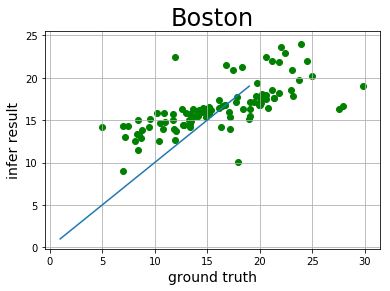

In [20]:
with fluid.scope_guard(inference_scope):#修改全局/默认作用域（scope）, 运行时中的所有变量都将分配给新的scope。
    #从指定目录中加载 推理model(inference model)
    [inference_program,                             #推理的program
     feed_target_names,                             #需要在推理program中提供数据的变量名称
     fetch_targets] = fluid.io.load_inference_model(#fetch_targets: 推断结果
                                    model_save_dir, #model_save_dir:模型训练路径 
                                    infer_exe)      #infer_exe: 预测用executor
    #获取预测数据
    infer_reader = paddle.batch(paddle.dataset.uci_housing.test(),  #获取uci_housing的测试数据
                          batch_size=200)                           #从测试数据中读取一个大小为200的batch数据
    #从test_reader中分割x
    test_data = next(infer_reader())
    test_x = np.array([data[0] for data in test_data]).astype("float32")
    test_y= np.array([data[1] for data in test_data]).astype("float32")
    results = infer_exe.run(inference_program,                              #预测模型
                            feed={feed_target_names[0]: np.array(test_x)},  #喂入要预测的x值
                            fetch_list=fetch_targets)                       #得到推测结果 
                            
    print("infer results and ground truth: (House Price)")
    for idx, val in enumerate(zip(results[0], test_y)):
        print("%d: infer:%.2f   gt:%.2f" % (idx, val[0], val[1]))
        infer_results.append(val[0])
        groud_truths.append(val[1])
    draw_infer_result(groud_truths,infer_results)